# Load packages and topology

In [146]:
import MDAnalysis as mda
import os
import numpy as np
import freud
import matplotlib.pyplot as plt

In [147]:
lipids = 128
steps = 600000
timestep = 0.01
timescale = 91.4 # ps
time_per_frame = 600000/300*0.01*0.0914 #ns
print(time_per_frame)

1.8279999999999998


In [ ]:
dir = "/home/gabriel/Dokumente/bachelor_thesis/dpd_simulation/lipid_self_assembly/"
top_file = os.path.join(dir, f"setup/lammps_{lipids}.data")
traj_file = os.path.join(dir, f"assembly/trajectories_{lipids}.lammpstrj")

In [149]:
# dir2 = "/home/gabriel/Dokumente/bachelor_thesis/dpd_simulation/bending_modulus/"
# top_file = os.path.join(dir2, "tests/bilayer.data")
# traj_file = os.path.join(dir2, "tests/bilayer.lammpstrj")

In [150]:
u = mda.Universe(top_file, format="DATA", atom_style = "id resid type charge x y z")

print("=== Topology loaded ===")
print(f"Total atoms: {len(u.atoms)}")
print(f"Total residues: {len(u.residues)}")

=== Topology loaded ===
Total atoms: 4608
Total residues: 3200


# Load both trajectrories and extract data

In [151]:
u.load_new(traj_file, format="LAMMPSDUMP", dt=1.0)

frames = len(u.trajectory)

all_frames_mol_positions = []

for frame in u.trajectory:

    frame_mol_positions = []

    for mol in u.residues:

        # only lipids
        if len(mol.atoms) == 12:
            frame_mol_positions.append(mol.atoms.positions.copy())

    all_frames_mol_positions.append(frame_mol_positions)
all_frames_box = np.full((frames,3), u.dimensions[:3])

print("info shape: ", np.shape(all_frames_mol_positions))
print("info shape box: ", np.shape(all_frames_box))

info shape:  (301, 128, 12, 3)
info shape box:  (301, 3)


# Load comp bilayer

In [152]:
top_comp_file = os.path.join(dir, "comparison/popc-bilayer/test/test.gro")
traj_comp_file = os.path.join(dir, "comparison/popc-bilayer/test/test.xtc")

u_comp = mda.Universe(top_comp_file, traj_comp_file)

In [153]:
traj_comp_dpd_file = os.path.join(dir, f"comparison/comp_{lipids}.lammpstrj")
top_comp_dpd_file = os.path.join(dir, f"setup/bilayer_{lipids}.data")

In [154]:
u_dpd = mda.Universe(top_comp_dpd_file, format="DATA", atom_style = "id resid type charge x y z")
u_dpd.load_new(traj_comp_dpd_file, format="LAMMPSDUMP", dt=1.0)

<Universe with 4402 atoms>

In [155]:
frames = len(u_dpd.trajectory)

comp_dpd_all_frames_mol_positions = []

for frame in u_dpd.trajectory:

    comp_dpd_frame_mol_positions = []

    for mol in u_dpd.residues:

        # only lipids
        if len(mol.atoms) == 12:
            comp_dpd_frame_mol_positions.append(mol.atoms.positions.copy())

    comp_dpd_all_frames_mol_positions.append(comp_dpd_frame_mol_positions)
comp_dpd_all_frames_box = np.full((frames,3), u_dpd.dimensions[0])

In [156]:
comp_all_frames_mol_positions = []
comp_all_frames_box = []

for frame in u_comp.trajectory:

    comp_frame_mol_positions = []

    for mol in u_comp.residues:

        # only lipids
        if len(mol.atoms) == 12:
            positions_nm = mol.atoms.positions.copy() / 10.0
            comp_frame_mol_positions.append(positions_nm)

    comp_all_frames_mol_positions.append(comp_frame_mol_positions)
    comp_all_frames_box.append(u_comp.dimensions[:3].copy()/10.0)

# Unwrap molecules
 bonds no longer beyond box

In [157]:
# unwraps all molecules

def unwrap(universe,box):

    for (frame,box_dims) in zip(universe,box):
        for i,mol in enumerate(frame):
            
            ref = mol[0]

            delta = mol - ref
            delta = delta - box_dims*np.round(delta/box_dims)

            unwrapped = ref + delta

            frame[i] = unwrapped

In [158]:
unwrap(all_frames_mol_positions, all_frames_box)

In [159]:
unwrap(comp_all_frames_mol_positions, comp_all_frames_box)

In [160]:
unwrap(comp_dpd_all_frames_mol_positions, comp_dpd_all_frames_box)

# Contact number
## Calculate COMs

In [161]:
def coms(universe):

    n_frames = np.shape(universe)[0]
    n_lipids = np.shape(universe)[1]

    all_coms = np.zeros((n_frames, n_lipids, 3))

    for i, frame in enumerate(universe):
        for j, mol in enumerate(frame):

            mol = np.array(mol)
            com = np.mean(mol, axis=0)

            all_coms[i][j] = com

    return all_coms



In [162]:
all_coms = coms(all_frames_mol_positions)

In [163]:
comp_all_coms = coms(comp_all_frames_mol_positions)

In [ ]:
comp_dpd_all_coms = coms(comp_dpd_all_frames_mol_positions)

(301, 3)


calculate contact number with neares image convention

In [165]:
def calc_contact_number(coms,cutoff,box,n_bins=50):

    contact_number = np.zeros(np.shape(coms)[0])

    for i,(frame_com,box_dims) in enumerate(zip(coms,box)):

        dists = frame_com[:,None,:] - frame_com[None,:,:]
        
        dists = dists - box_dims*np.round(dists/box_dims)
        dists = np.linalg.norm(dists, axis=2)


        np.fill_diagonal(dists,np.inf)

        neighbors_per_lipid = (dists <= cutoff).sum(axis=1)

        contact_number[i] = neighbors_per_lipid.mean()

    return contact_number

In [166]:
dpd_apl = all_frames_box[0][0]*all_frames_box[0][1]/(lipids/2)
dpd_rad = np.sqrt(dpd_apl/np.pi)

In [167]:
contact_number = calc_contact_number(all_coms,2*dpd_rad,all_frames_box)

In [168]:
comp_mean_box_dims = np.mean(comp_all_frames_box, axis=0)
gro_apl = comp_mean_box_dims[0]*comp_mean_box_dims[1]/(64)
gro_rad = np.sqrt(gro_apl/np.pi)

In [169]:
comp_contact_number = calc_contact_number(comp_all_coms,2*gro_rad, comp_all_frames_box)
comp_mean_contact = np.mean(comp_contact_number)
comp_std_contact = np.std(comp_contact_number)

In [170]:
comp_dpd_contact_number = calc_contact_number(comp_dpd_all_coms, 2*dpd_rad, comp_dpd_all_frames_box)

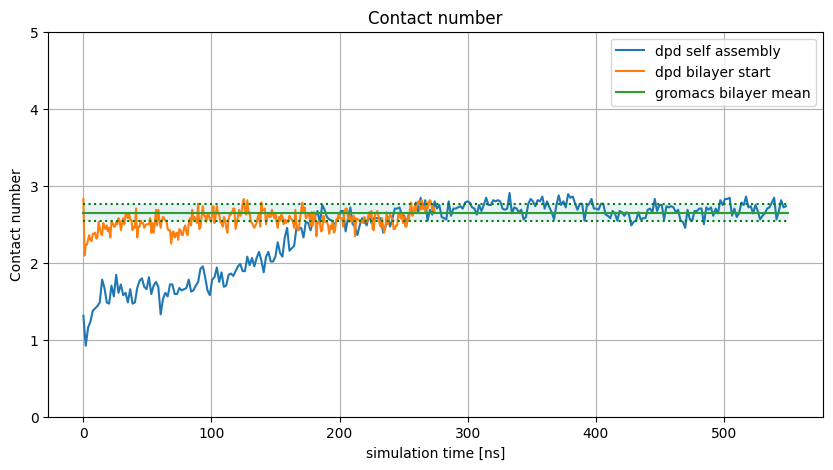

In [171]:
plt.figure(figsize=(10,5))

plt.plot(np.arange(len(contact_number))*time_per_frame,contact_number, label="dpd self assembly")
plt.xlabel("simulation time [ns]")
plt.ylabel("Contact number")
plt.title("Contact number")
plt.ylim((0,5))

plt.plot(np.arange(len(comp_dpd_contact_number))*time_per_frame/2,comp_dpd_contact_number, label="dpd bilayer start")

plt.plot([0,550], [comp_mean_contact+comp_std_contact, comp_mean_contact+comp_std_contact], linestyle="dotted", color="green")
plt.plot([0,550], [comp_mean_contact, comp_mean_contact], label="gromacs bilayer mean")
plt.plot([0,550], [comp_mean_contact-comp_std_contact, comp_mean_contact-comp_std_contact], linestyle="dotted", color="green")
plt.fill_between(np.linspace(0,550,50), np.full(50, comp_mean_contact-comp_std_contact), np.full(50, comp_mean_contact+comp_std_contact), alpha=0.1)


plt.grid()
plt.legend()
plt.show()

# Calculate Nematic tensor

In [172]:
nematic = freud.order.Nematic()

In [173]:
def calc_nematic(universe):

    S_values = np.zeros((np.shape(universe)[0]))
    directors = np.zeros((np.shape(universe)[0],3))

    for i,frame in enumerate(universe):
        orientations = np.zeros((np.shape(universe)[1],3))
        for j,mol in enumerate(frame):

            head = mol[0]
            tail = (mol[7] + mol[11])/2

            u = (tail - head)/np.linalg.norm(tail - head)

            orientations[j] = u 

        nematic.compute(orientations)

        S_values[i] = nematic.order
        directors[i] = nematic.director
    
    return S_values, directors

In [174]:
S_values, directors = calc_nematic(all_frames_mol_positions)

In [175]:
comp_S_values, _ = calc_nematic(comp_all_frames_mol_positions)
comp_mean_S = np.mean(comp_S_values)
comp_std_S = np.std(comp_S_values)

In [176]:
comp_dpd_S_values, _ = calc_nematic(comp_dpd_all_frames_mol_positions)

In [177]:
high_temp = 50
cool_down = 100
equil = frames

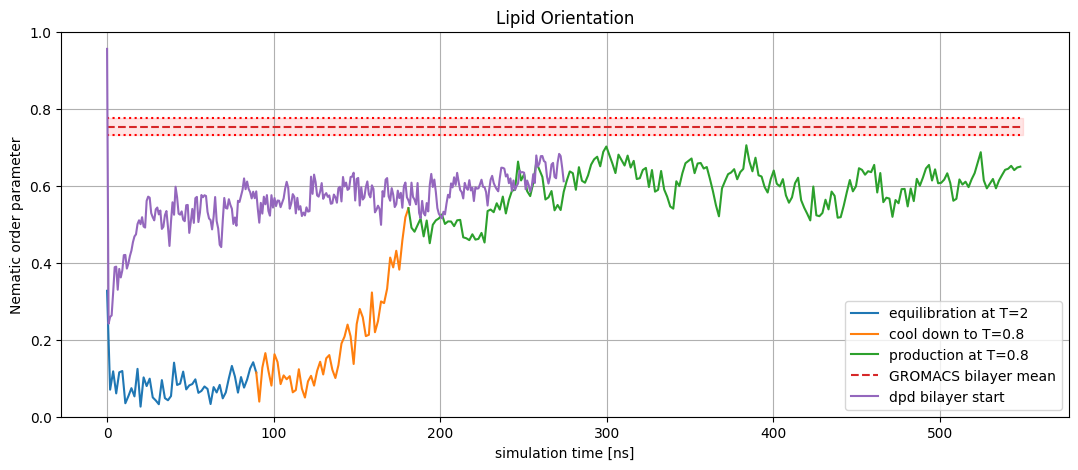

In [178]:
plt.figure(figsize=(13,5))
frame_axis = np.arange(0,frames)

plt.plot(frame_axis[:50]*time_per_frame,S_values[:50], label="equilibration at T=2")
plt.plot(frame_axis[49:100]*time_per_frame,S_values[49:100], label="cool down to T=0.8")
plt.plot(frame_axis[99:]*time_per_frame,S_values[99:], label="production at T=0.8")

plt.plot([0,550], [comp_mean_S-comp_std_S, comp_mean_S-comp_std_S], linestyle="dotted", color="red")
plt.plot([0,550], [comp_mean_S, comp_mean_S], label="GROMACS bilayer mean", linestyle="dashed")
plt.plot([0,550], [comp_mean_S+comp_std_S, comp_mean_S+comp_std_S], linestyle="dotted", color="red")
plt.fill_between(np.linspace(0,550,50), np.full(50,comp_mean_S+comp_std_S), np.full(50,comp_mean_S-comp_std_S), color="r", alpha=0.1)

plt.plot(np.arange(len(comp_dpd_S_values))*time_per_frame/2,comp_dpd_S_values, label="dpd bilayer start")
plt.ylim((0,1))
plt.xlabel("simulation time [ns]")
plt.ylabel("Nematic order parameter")
plt.title("Lipid Orientation")

plt.grid()
plt.legend()
plt.show()

# Bilayer structure

In [182]:
def calc_density_profile_avg(universe, directors, frame_start, frame_end, box, n_bins=50):

    proj_heads = []
    proj_links = []
    proj_tails = []
    proj_terminal = []

    proj_heads_per_lipid = []

    for frame_id in range(frame_start, frame_end):

        frame = universe[frame_id]
        director = directors[frame_id]

        if director[2] < 0:
            director = -director

        lipid_coms = np.array([np.mean(mol, axis=0) for mol in frame])
        box_dims = box[frame_id]
        
        ref_com = lipid_coms[0]
        delta_coms = lipid_coms - ref_com
        delta_coms = delta_coms - box_dims * np.round(delta_coms / box_dims)
        lipid_coms_unwrapped = ref_com + delta_coms
        
        bilayer_center = np.mean(lipid_coms_unwrapped, axis=0)

        for i,mol in enumerate(frame):

            mol_shift = lipid_coms_unwrapped[i] - lipid_coms[i]
            
            head_projs = []
            for j in [0,1]:
                proj = np.dot((mol[j] + mol_shift - bilayer_center),director)
                proj_heads.append(proj)
                head_projs.append(proj)

            for j in [2,3]:
                proj = np.dot((mol[j] + mol_shift - bilayer_center),director)
                proj_links.append(proj)
            
            proj_heads_per_lipid.append(np.mean(head_projs))
            
            for j in [7,11]:
                proj = np.dot((mol[j] + mol_shift - bilayer_center),director)
                proj_terminal.append(proj)

            for j in [4,5,6,8,9,10]:
                proj = np.dot((mol[j] + mol_shift - bilayer_center),director)
                proj_tails.append(proj)

    proj_heads, proj_tails, proj_links, proj_heads_per_lipid = np.array(proj_heads), np.array(proj_tails), np.array(proj_links), np.array(proj_heads_per_lipid)
    all_proj = np.concatenate([proj_heads, proj_links, proj_tails])
    center = np.mean(all_proj)

    proj_heads -= center
    proj_tails -= center
    proj_links -= center
    proj_terminal -= center
    proj_heads_per_lipid -= center

    left_tails = []
    right_tails = []

    for lipid_id in range(len(proj_heads_per_lipid)):
        
        start = 2*lipid_id
        end = 2*lipid_id + 2
        lipid_tails = [proj_terminal[start:end]]

        if proj_heads_per_lipid[lipid_id] < 0:
            left_tails.append(lipid_tails)
        else:
            right_tails.append(lipid_tails)
    

    bins_ovl = np.linspace(-3, 3, n_bins)
    bin_centers_ovl = (bins_ovl[:-1] + bins_ovl[1:]) / 2
    
    hist_left, _ = np.histogram(left_tails, bins=bins_ovl)
    hist_right, _ = np.histogram(right_tails, bins=bins_ovl)

    proj_min, proj_max = np.percentile(all_proj - center, [1,99])

    proj_min, proj_max = proj_min-1, proj_max+1

    bins = np.linspace(proj_min, proj_max, n_bins+1)
    bin_centers = (bins[:-1] + bins[1:])/2
    bin_width = bins[1] - bins[0]

    hist_heads, _ = np.histogram(proj_heads, bins=bins)
    hist_links, _ = np.histogram(proj_links, bins=bins)
    hist_tails, _ = np.histogram(proj_tails, bins=bins)
    hist_terminal, _ = np.histogram(proj_terminal, bins=bins)

    box_dims = box[frame_start]
    area = box_dims[0] * box_dims[1]
    bin_vol = area * bin_width
    n_frames = frame_end - frame_start

    hist_heads = hist_heads / (bin_vol * n_frames)
    hist_links = hist_links / (bin_vol * n_frames)
    hist_tails = hist_tails / (bin_vol * n_frames)
    hist_terminal = hist_terminal / (bin_vol * n_frames)

    hist_left = hist_left/(area*(bins_ovl[1] - bins_ovl[0])*n_frames)
    hist_right = hist_right/(area*(bins_ovl[1] - bins_ovl[0])*n_frames)

    print(f"Monolayer right: {len(right_tails)/n_frames}, monolayer left: {len(left_tails)/n_frames}")

    return hist_heads, hist_links, hist_tails, hist_terminal, bin_centers, hist_left, hist_right, bin_centers_ovl



In [183]:
heads, links, tails, terminal, bin_centers, left, right, bin_centers_ovl = calc_density_profile_avg(all_frames_mol_positions, directors, 160, frames, all_frames_box, n_bins=150)

Monolayer right: 65.0709219858156, monolayer left: 62.9290780141844


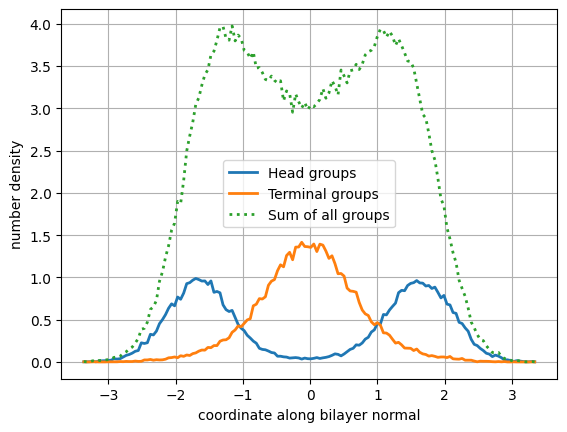

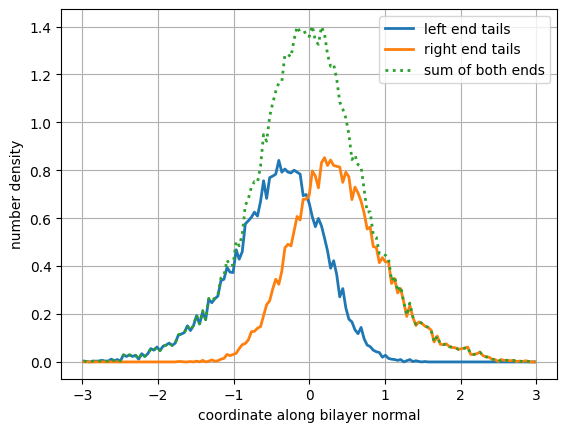

In [184]:
plt.plot(bin_centers, heads, label='Head groups', linewidth=2)
#plt.plot(bin_centers, links, label='Link groups', linewidth=2)
#plt.plot(bin_centers, tails, label='Tail groups', linewidth=2)
plt.plot(bin_centers, terminal, label='Terminal groups', linewidth=2)
plt.plot(bin_centers, heads+links+tails+terminal, label="Sum of all groups", linewidth=2, linestyle="dotted")
plt.xlabel("coordinate along bilayer normal")
plt.ylabel("number density")

plt.grid()
plt.legend()
plt.show()

plt.plot(bin_centers_ovl,left, label="left end tails", linewidth=2)
plt.plot(bin_centers_ovl,right, label="right end tails", linewidth=2)
plt.plot(bin_centers_ovl,right+left, label="sum of both ends", linewidth=2, linestyle="dotted")
plt.xlabel("coordinate along bilayer normal")
plt.ylabel("number density")
plt.grid()
plt.legend()